Illustration/tutorial by Alan Saul - 07 March 2016

Looks at modelling a space-time effect, and a multiplier which is a spatial effect. 

*Work in progress*.

$\lambda = \exp(f(s, t)) · e_s) = exp(f(s,t) + \log(e_s))$

$y_{s,t} | λ(s, t) ∼ Poisson(\lambda)$


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import GPy
from scipy.stats import poisson
np.random.seed(100)
%matplotlib inline

In [2]:
#Determine our inputs
space = np.linspace(0,5)[:, None]
time = np.linspace(0,1)[:, None]

space_grid, time_grid = np.meshgrid(space,time)
#Stack grid observations into two columns of features
X = np.vstack([space_grid.ravel(), time_grid.ravel()]).T

# Make a kernel for the space_time effect, f
kern_f = GPy.kern.RBF(2, active_dims=[0,1], name='space_time_kern')
# Make a kernel for the spatial only effect (which is in log space)
kern_s_effect = GPy.kern.RBF(1, active_dims=[0], name='space_effect')

#Generate our truth effects from a GP (sampling from the assumed model to generate the data)
Kf = kern_f.K(X)
Ke_s = kern_s_effect.K(X[:,0:1])
truth_f = GPy.util.linalg.jitchol(Kf).dot(np.random.randn(X.shape[0]))
truth_log_e_s = GPy.util.linalg.jitchol(Ke_s).dot(np.random.randn(X.shape[0]))

#Lambda is exp(f(s,t))*e_s = exp(f(s,t) + log(e_s))
truth_lamda = np.exp(truth_f + truth_log_e_s)[:, None]

Y = np.array([poisson.rvs(truth_lamda[i]) for i in range(truth_f.shape[0])])[:, None]

In [3]:
# In practice you won't have all of these locations 
# Here we subsample our observations 
known_indices = np.random.permutation(range(X.shape[0]))[:500]
known_X = X[known_indices]
known_Y = Y[known_indices]

In [4]:
# Rearrange data into grids for plotting
truth_lamda_grid = truth_lamda.reshape(space.shape[0], time.shape[0])
Y_grid = Y.reshape(space.shape[0], time.shape[0])
truth_f_grid = truth_f.reshape(space.shape[0], time.shape[0])
truth_log_e_s_grid = truth_log_e_s.reshape(space.shape[0], time.shape[0])

Plot the overall truth rate with observations

<matplotlib.colorbar.Colorbar instance at 0x7f619e35b200>

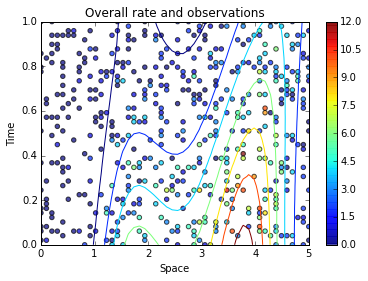

In [5]:
plt.title('Overall rate and observations')
plt.contour(space_grid, time_grid, truth_lamda_grid)
plt.scatter(known_X[:,0], known_X[:,1], c=known_Y, alpha=0.7)
plt.xlabel('Space')
plt.ylabel('Time')
plt.xlim(space_grid.min(), space_grid.max())
plt.ylim(time_grid.min(), time_grid.max())
plt.colorbar()

Plot just the space-time effect (effect from one kernel)

<matplotlib.colorbar.Colorbar instance at 0x7f619c929e18>

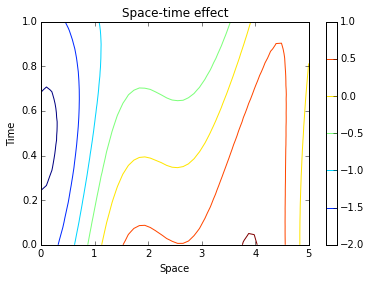

In [6]:
plt.title('Space-time effect')
plt.contour(space_grid, time_grid, truth_f_grid)
plt.xlabel('Space')
plt.ylabel('Time')
plt.xlim(space_grid.min(), space_grid.max())
plt.ylim(time_grid.min(), time_grid.max())
plt.colorbar()

Plot just the space multiplier effect (from the other kenel) 

<matplotlib.colorbar.Colorbar instance at 0x7f619c7fc518>

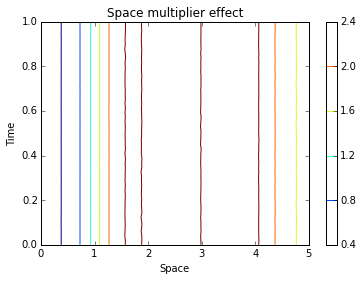

In [7]:
plt.title('Space multiplier effect')
plt.contour(space_grid, time_grid, np.exp(truth_log_e_s_grid))
plt.xlabel('Space')
plt.ylabel('Time')
plt.xlim(space_grid.min(), space_grid.max())
plt.ylim(time_grid.min(), time_grid.max())
plt.colorbar()

Now lets make a model for our observations

In [8]:
likelihood = GPy.likelihoods.Poisson()
inference_method = GPy.inference.latent_function_inference.Laplace()
full_kern = kern_f + kern_s_effect
m = GPy.core.GP(X=known_X, Y=known_Y, kernel=full_kern, likelihood=likelihood, inference_method=inference_method)
m.randomize()
m.optimize(messages=True)

Plot overall rate predictions

In [9]:
pred_mean, pred_variance = m._raw_predict(X)
pred_mean = np.exp(pred_mean)
pred_mean_grid = pred_mean.reshape(space.shape[0], time.shape[0])

<matplotlib.colorbar.Colorbar instance at 0x7f619c784098>

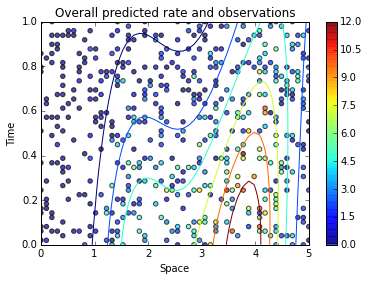

In [10]:
plt.title('Overall predicted rate and observations')
plt.contour(space_grid, time_grid, pred_mean_grid)
plt.scatter(known_X[:,0], known_X[:,1], c=known_Y, alpha=0.7)
plt.xlabel('Space')
plt.ylabel('Time')
plt.xlim(space_grid.min(), space_grid.max())
plt.ylim(time_grid.min(), time_grid.max())
plt.colorbar()

Plot effect from space-time kernel

In [11]:
pred_mean_space_time, _ = m._raw_predict(X, kern=m.kern.space_time_kern)
pred_mean_space_time = np.exp(pred_mean_space_time)
pred_mean_space_time_grid = pred_mean_space_time.reshape(space.shape[0], time.shape[0])

<matplotlib.colorbar.Colorbar instance at 0x7f619c565878>

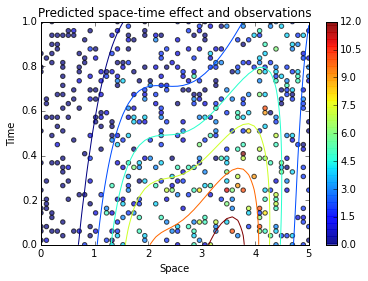

In [12]:
plt.title('Predicted space-time effect and observations')
plt.contour(space_grid, time_grid, pred_mean_space_time_grid)
plt.scatter(known_X[:,0], known_X[:,1], c=known_Y, alpha=0.7)
plt.xlabel('Space')
plt.ylabel('Time')
plt.xlim(space_grid.min(), space_grid.max())
plt.ylim(time_grid.min(), time_grid.max())
plt.colorbar()

Plot effect from just spatial effect multiplier

In [13]:
pred_mean_space_time, _ = m._raw_predict(X, kern=m.kern.space_effect)
pred_mean_space_time = np.exp(pred_mean_space_time)
pred_mean_space_time_grid = pred_mean_space_time.reshape(space.shape[0], time.shape[0])

<matplotlib.colorbar.Colorbar instance at 0x7f619c3c9368>

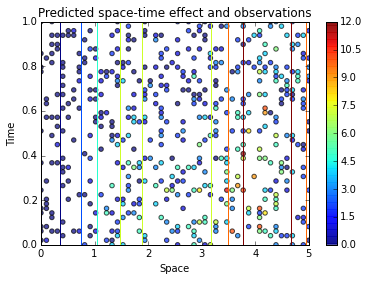

In [14]:
plt.title('Predicted space-time effect and observations')
plt.contour(space_grid, time_grid, pred_mean_space_time_grid)
plt.scatter(known_X[:,0], known_X[:,1], c=known_Y, alpha=0.7)
plt.xlabel('Space')
plt.ylabel('Time')
plt.xlim(space_grid.min(), space_grid.max())
plt.ylim(time_grid.min(), time_grid.max())
plt.colorbar()